# Part 3.3: Applying RL Concepts to CliffWalking

In the previous notebooks, we learned fundamental RL concepts using the FrozenLake environment. Now it's time to apply everything we've learned to a **new environment**: CliffWalking.

This notebook is different from the teaching notebooks. We won't re-explain concepts - instead, we'll:
1. Apply them to a new problem
2. Focus on how **determinism** changes everything
3. See the algorithms in action

## What This Notebook Covers
- Applying Markov chains, MRPs, and MDPs to CliffWalking
- How deterministic transitions simplify analysis
- Policy iteration and value iteration on a deterministic environment
- Comparing results with stochastic FrozenLake

## What This Notebook Does NOT Cover

| Topic | Why Not | Where to Find It |
|-------|---------|------------------|
| **Teaching RL concepts from scratch** | We assume you've completed notebooks 01-03_2 | Notebooks 01_1 through 03_2 |
| **Model-free methods** | We use the known model (dynamic programming) | Coming in notebooks 04-06 |
| **Deriving equations** | Focus is on application, not derivation | Notebooks 02_1 through 02_4 |

## Prerequisites
- Completed all previous notebooks (01_1 through 03_2)
- Understanding of Markov chains, MRPs, MDPs
- Familiarity with policy iteration and value iteration

Let's see how these concepts apply to a deterministic world!

---
## Setup

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

print("Setup complete!")

Setup complete!


In [2]:
# Create the CliffWalking environment
env = gym.make("CliffWalking-v1")
env.reset(seed=42)

n_states = env.observation_space.n
n_actions = env.action_space.n

print(f"CliffWalking Environment")
print("=" * 40)
print(f"Number of states: {n_states}")
print(f"Number of actions: {n_actions}")
print(f"\nAction mapping: 0=UP, 1=RIGHT, 2=DOWN, 3=LEFT")

CliffWalking Environment
Number of states: 48
Number of actions: 4

Action mapping: 0=UP, 1=RIGHT, 2=DOWN, 3=LEFT


---
# 1. The CliffWalking Environment

CliffWalking is a classic RL environment from Sutton & Barto's textbook. Unlike FrozenLake, it has:

| Feature | FrozenLake | CliffWalking |
|---------|------------|---------------|
| Grid size | 4×4 (16 states) | 4×12 (48 states) |
| Transitions | Stochastic (slippery ice) | **Deterministic** |
| Rewards | Sparse (+1 at goal only) | Dense (-1 per step, -100 cliff) |
| Danger | Holes (episode ends) | Cliff (returns to start) |

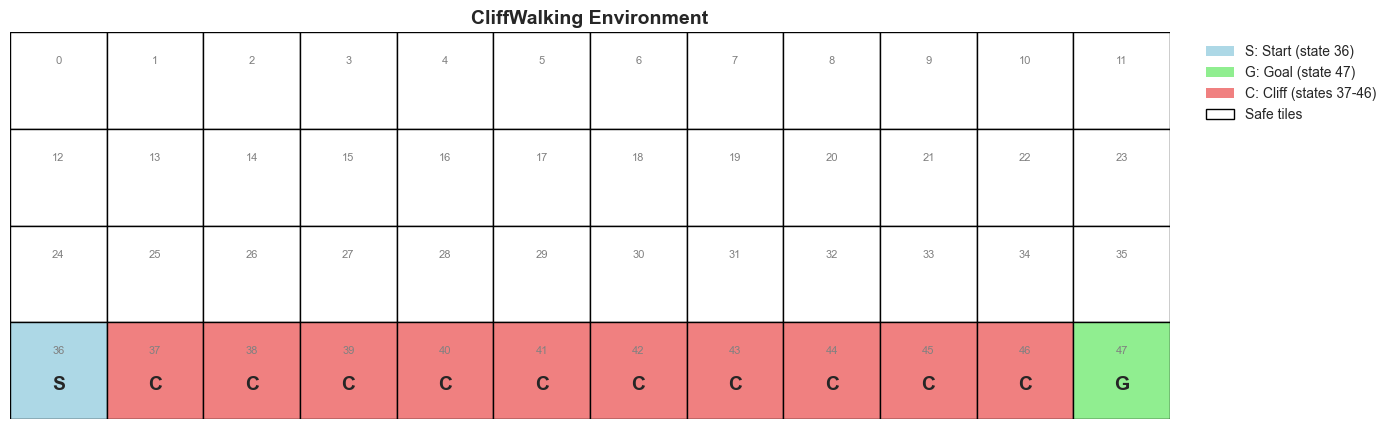


Grid layout:
- Agent starts at S (state 36, bottom-left)
- Goal is at G (state 47, bottom-right)
- The cliff (C) stretches along the bottom row
- Stepping on the cliff: reward = -100, return to start
- Every other step: reward = -1


In [3]:
def visualize_cliffwalking(current_state=None, title="CliffWalking Environment"):
    """Visualize the CliffWalking grid."""
    nrow, ncol = 4, 12
    
    fig, ax = plt.subplots(figsize=(14, 5))
    
    for i in range(nrow):
        for j in range(ncol):
            state = i * ncol + j
            
            # Determine cell type
            if state == 36:  # Start
                color = 'lightblue'
                label = 'S'
            elif state == 47:  # Goal
                color = 'lightgreen'
                label = 'G'
            elif 37 <= state <= 46:  # Cliff
                color = 'lightcoral'
                label = 'C'
            else:  # Safe
                color = 'white'
                label = ''
            
            # Highlight current state
            if current_state is not None and state == current_state:
                edgecolor = 'blue'
                linewidth = 3
            else:
                edgecolor = 'black'
                linewidth = 1
            
            rect = plt.Rectangle((j, nrow-1-i), 1, 1, fill=True,
                                 facecolor=color, edgecolor=edgecolor, linewidth=linewidth)
            ax.add_patch(rect)
            
            # Add state number and label
            ax.text(j + 0.5, nrow - 1 - i + 0.7, str(state),
                   ha='center', va='center', fontsize=8, color='gray')
            if label:
                ax.text(j + 0.5, nrow - 1 - i + 0.35, label,
                       ha='center', va='center', fontsize=14, fontweight='bold')
    
    ax.set_xlim(0, ncol)
    ax.set_ylim(0, nrow)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    # Legend
    legend_elements = [
        plt.Rectangle((0, 0), 1, 1, facecolor='lightblue', label='S: Start (state 36)'),
        plt.Rectangle((0, 0), 1, 1, facecolor='lightgreen', label='G: Goal (state 47)'),
        plt.Rectangle((0, 0), 1, 1, facecolor='lightcoral', label='C: Cliff (states 37-46)'),
        plt.Rectangle((0, 0), 1, 1, facecolor='white', edgecolor='black', label='Safe tiles'),
    ]
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1))
    
    plt.tight_layout()
    return fig, ax

visualize_cliffwalking()
plt.show()

print("\nGrid layout:")
print("- Agent starts at S (state 36, bottom-left)")
print("- Goal is at G (state 47, bottom-right)")
print("- The cliff (C) stretches along the bottom row")
print("- Stepping on the cliff: reward = -100, return to start")
print("- Every other step: reward = -1")

## 1.1 State Encoding

States are encoded as integers from 0 to 47:

$$\text{state} = \text{row} \times 12 + \text{col}$$

This is the same pattern as FrozenLake, but with a 4×12 grid instead of 4×4.

In [4]:
def state_to_pos(state):
    """Convert state number to (row, col) position."""
    return state // 12, state % 12

def pos_to_state(row, col):
    """Convert (row, col) position to state number."""
    return row * 12 + col

# Demonstrate encoding
print("State Encoding Examples")
print("=" * 40)
for state in [0, 11, 36, 47, 23]:
    row, col = state_to_pos(state)
    print(f"State {state:2d} → Position (row={row}, col={col})")

State Encoding Examples
State  0 → Position (row=0, col=0)
State 11 → Position (row=0, col=11)
State 36 → Position (row=3, col=0)
State 47 → Position (row=3, col=11)
State 23 → Position (row=1, col=11)


## 1.2 Action Space

CliffWalking has 4 actions, but with a **different mapping** than FrozenLake:

| Action | CliffWalking | FrozenLake |
|--------|--------------|------------|
| 0 | UP | LEFT |
| 1 | RIGHT | DOWN |
| 2 | DOWN | RIGHT |
| 3 | LEFT | UP |

This is an important detail when adapting code!

In [5]:
# Action names for CliffWalking
action_names = {0: 'UP', 1: 'RIGHT', 2: 'DOWN', 3: 'LEFT'}
action_arrows = {0: '↑', 1: '→', 2: '↓', 3: '←'}

print("CliffWalking Actions")
print("=" * 40)
for a, name in action_names.items():
    print(f"Action {a}: {name} ({action_arrows[a]})")

CliffWalking Actions
Action 0: UP (↑)
Action 1: RIGHT (→)
Action 2: DOWN (↓)
Action 3: LEFT (←)


## 1.3 The Key Difference: Deterministic Transitions

This is the most important difference from FrozenLake.

**FrozenLake (Stochastic):**
- When you choose action RIGHT, you go:
  - RIGHT with probability 1/3
  - UP with probability 1/3
  - DOWN with probability 1/3

**CliffWalking (Deterministic):**
- When you choose action RIGHT, you go:
  - RIGHT with probability **1.0**

Let's verify this by examining the transition probabilities:

In [6]:
print("Verifying Deterministic Transitions")
print("=" * 50)

# Look at transitions from state 25 (middle of grid)
test_state = 25
print(f"\nTransitions from state {test_state} (row 2, col 1):")
print("-" * 50)

for action in range(n_actions):
    transitions = env.unwrapped.P[test_state][action]
    print(f"\nAction {action} ({action_names[action]}):")
    for prob, next_state, reward, done in transitions:
        print(f"  → State {next_state} with probability {prob:.2f}, reward={reward}")

print("\n" + "=" * 50)
print("Notice: Every action leads to exactly ONE state with probability 1.0!")
print("This is what 'deterministic' means: no uncertainty in transitions.")

Verifying Deterministic Transitions

Transitions from state 25 (row 2, col 1):
--------------------------------------------------

Action 0 (UP):
  → State 13 with probability 1.00, reward=-1

Action 1 (RIGHT):
  → State 26 with probability 1.00, reward=-1

Action 2 (DOWN):
  → State 36 with probability 1.00, reward=-100

Action 3 (LEFT):
  → State 24 with probability 1.00, reward=-1

Notice: Every action leads to exactly ONE state with probability 1.0!
This is what 'deterministic' means: no uncertainty in transitions.


In [7]:
# Special case: What happens when stepping on the cliff?
print("What Happens When You Step on the Cliff?")
print("=" * 50)

# From state 36 (Start), action RIGHT leads to cliff
start_state = 36
print(f"\nFrom state {start_state} (Start), action RIGHT:")
transitions = env.unwrapped.P[start_state][1]  # Action 1 = RIGHT
for prob, next_state, reward, done in transitions:
    print(f"  → State {next_state} with probability {prob:.2f}")
    print(f"     Reward: {reward}")
    print(f"     Episode done: {done}")

print("\nThe cliff gives -100 reward and returns you to the Start!")

What Happens When You Step on the Cliff?

From state 36 (Start), action RIGHT:
  → State 36 with probability 1.00
     Reward: -100
     Episode done: False

The cliff gives -100 reward and returns you to the Start!


## 1.4 Implications of Determinism

Deterministic transitions have profound implications:

| Aspect | Stochastic (FrozenLake) | Deterministic (CliffWalking) |
|--------|------------------------|------------------------------|
| **Policy → Trajectory** | Same policy → different trajectories | Same policy → same trajectory |
| **Credit assignment** | Which action caused this outcome? | Clear cause and effect |
| **Optimal policy** | Best we can do: ~74% success | Best we can do: **100% success** |
| **Value function** | Expected value over outcomes | Single deterministic outcome |
| **Algorithm convergence** | Many iterations (uncertainty) | Fewer iterations (certainty) |

---
# 2. Markov Properties in CliffWalking

Let's verify that CliffWalking satisfies all the Markov properties we learned and build the corresponding structures.

## 2.1 The Markov Property

Recall: An environment has the Markov property if:

$$P[S_{t+1} | S_t] = P[S_{t+1} | S_1, S_2, ..., S_t]$$

**The future depends only on the present, not the history.**

Does CliffWalking satisfy this? Let's check:

In [8]:
# Verify Markov property by showing transitions depend only on current state
print("Verifying the Markov Property")
print("=" * 50)

# Run two different paths to the same state
env.reset()

# Path 1: Start → UP → RIGHT → DOWN (ends at state 37, cliff!)
# Actually let's use a safer example
# Path 1: Start(36) → UP(24) → UP(12) → RIGHT(13)
# Path 2: Start(36) → UP(24) → RIGHT(25) → UP(13)

print("\nPath 1 to state 13: 36 → UP → UP → RIGHT")
env.reset()
env.unwrapped.s = 36  # Start
_, _, _, _, _ = env.step(0)  # UP → 24
_, _, _, _, _ = env.step(0)  # UP → 12
obs1, _, _, _, _ = env.step(1)  # RIGHT → 13
print(f"  Final state: {obs1}")

# Check what happens next from state 13
transitions_path1 = env.unwrapped.P[13][1]  # Action RIGHT from state 13
print(f"  From state 13, action RIGHT leads to: {transitions_path1[0][1]}")

print("\nPath 2 to state 13: 36 → UP → RIGHT → UP")
env.reset()
env.unwrapped.s = 36  # Start
_, _, _, _, _ = env.step(0)  # UP → 24
_, _, _, _, _ = env.step(1)  # RIGHT → 25
obs2, _, _, _, _ = env.step(0)  # UP → 13
print(f"  Final state: {obs2}")

# Check what happens next from state 13 (same query)
transitions_path2 = env.unwrapped.P[13][1]  # Action RIGHT from state 13
print(f"  From state 13, action RIGHT leads to: {transitions_path2[0][1]}")

print("\n" + "=" * 50)
print("✓ Same state → Same transitions, regardless of history!")
print("  CliffWalking satisfies the Markov property.")

Verifying the Markov Property

Path 1 to state 13: 36 → UP → UP → RIGHT
  Final state: 13
  From state 13, action RIGHT leads to: 14

Path 2 to state 13: 36 → UP → RIGHT → UP
  Final state: 13
  From state 13, action RIGHT leads to: 14

✓ Same state → Same transitions, regardless of history!
  CliffWalking satisfies the Markov property.


## 2.2 Building a Markov Chain

Recall from notebook 02_1: A **Markov Chain** is a tuple $(S, P)$ where:
- $S$ is the set of states
- $P$ is the transition probability matrix

To create a Markov Chain from an MDP, we need to fix a policy. Let's use the **uniform random policy** (equal probability for each action).

In [9]:
def build_markov_chain(env, policy=None):
    """
    Build transition matrix P for Markov Chain.
    If policy is None, uses uniform random policy.
    
    P[s, s'] = probability of transitioning from s to s'
    """
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    
    # Default: uniform random policy
    if policy is None:
        policy = np.ones((n_states, n_actions)) / n_actions
    
    P = np.zeros((n_states, n_states))
    
    for s in range(n_states):
        for a in range(n_actions):
            for prob, next_s, reward, done in env.unwrapped.P[s][a]:
                # P[s,s'] = Σ_a π(a|s) × P(s'|s,a)
                P[s, next_s] += policy[s, a] * prob
    
    return P

# Build Markov Chain with random policy
P_chain = build_markov_chain(env)

print("Markov Chain Transition Matrix P (random policy)")
print("=" * 50)
print(f"Shape: {P_chain.shape}")
print(f"\nRow sums (should all be 1.0): {P_chain.sum(axis=1)[:5]}...")

Markov Chain Transition Matrix P (random policy)
Shape: (48, 48)

Row sums (should all be 1.0): [1. 1. 1. 1. 1.]...


**Question this plot answers:** 'What does a deterministic transition matrix look like?'



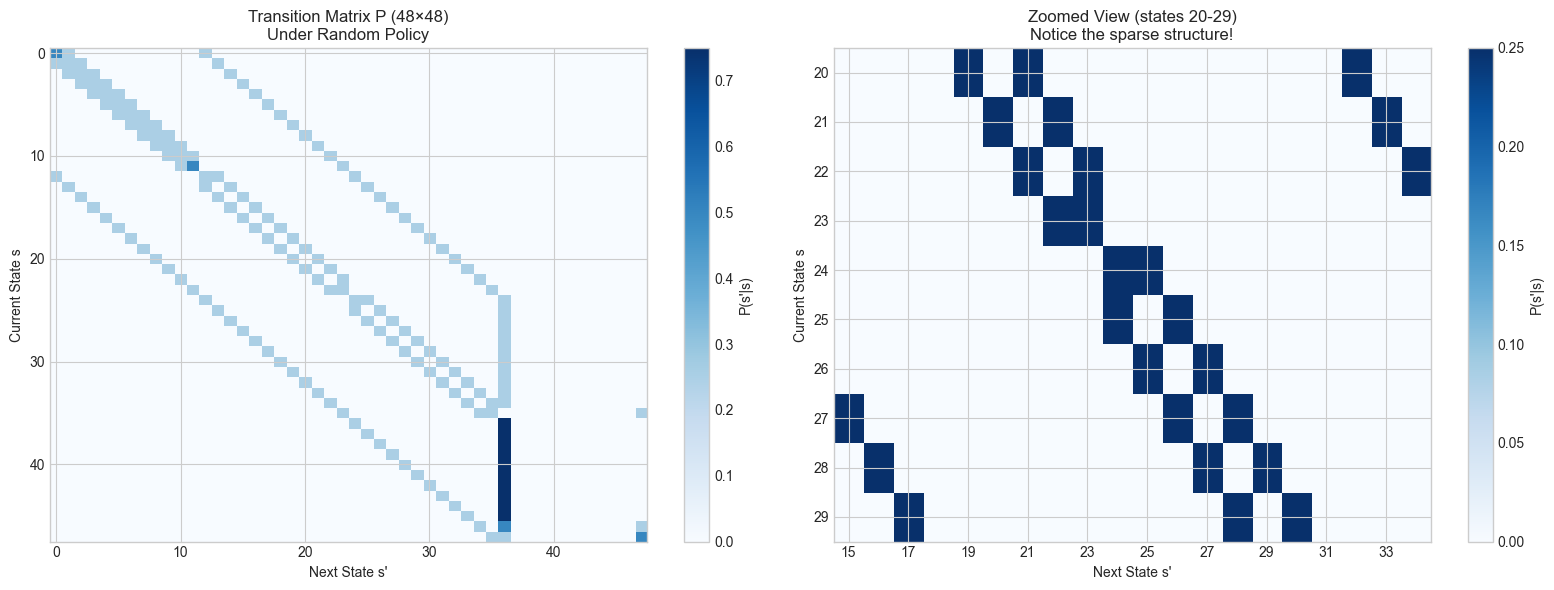

Observations:
- The matrix is very SPARSE (mostly zeros)
- Each row has only a few non-zero entries
- Under random policy: each state connects to ~4 neighbors
- This sparsity comes from determinism: each action → exactly one state


In [10]:
# Visualize the transition matrix
print("**Question this plot answers:** 'What does a deterministic transition matrix look like?'\n")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Full transition matrix
im = axes[0].imshow(P_chain, cmap='Blues', aspect='auto')
axes[0].set_title('Transition Matrix P (48×48)\nUnder Random Policy', fontsize=12)
axes[0].set_xlabel('Next State s\'')
axes[0].set_ylabel('Current State s')
plt.colorbar(im, ax=axes[0], label='P(s\'|s)')

# Zoom in on a portion
zoom_range = range(20, 30)
P_zoom = P_chain[20:30, 15:35]
im2 = axes[1].imshow(P_zoom, cmap='Blues', aspect='auto')
axes[1].set_title('Zoomed View (states 20-29)\nNotice the sparse structure!', fontsize=12)
axes[1].set_xlabel('Next State s\'')
axes[1].set_ylabel('Current State s')
axes[1].set_xticks(range(0, 20, 2))
axes[1].set_xticklabels(range(15, 35, 2))
axes[1].set_yticks(range(10))
axes[1].set_yticklabels(range(20, 30))
plt.colorbar(im2, ax=axes[1], label='P(s\'|s)')

plt.tight_layout()
plt.show()

print("Observations:")
print("- The matrix is very SPARSE (mostly zeros)")
print("- Each row has only a few non-zero entries")
print("- Under random policy: each state connects to ~4 neighbors")
print("- This sparsity comes from determinism: each action → exactly one state")

In [11]:
# Compare with what FrozenLake's matrix looks like
print("Transition Matrix Comparison: Deterministic vs Stochastic")
print("=" * 60)

# Count non-zero entries
nonzero_cliff = np.count_nonzero(P_chain)
total_entries = P_chain.size

print(f"\nCliffWalking (deterministic):")
print(f"  Matrix size: {P_chain.shape}")
print(f"  Non-zero entries: {nonzero_cliff} / {total_entries}")
print(f"  Sparsity: {(1 - nonzero_cliff/total_entries)*100:.1f}% zeros")

# Show transition values for a specific state
test_state = 25
print(f"\nFrom state {test_state}, transitions to:")
for next_s in range(n_states):
    if P_chain[test_state, next_s] > 0:
        print(f"  State {next_s}: P = {P_chain[test_state, next_s]:.2f}")

print("\nKey insight: Each action deterministically leads to ONE state.")
print("With 4 actions and equal probability (0.25 each), we get at most")
print("4 non-zero transitions per state, each with P = 0.25.")

Transition Matrix Comparison: Deterministic vs Stochastic

CliffWalking (deterministic):
  Matrix size: (48, 48)
  Non-zero entries: 168 / 2304
  Sparsity: 92.7% zeros

From state 25, transitions to:
  State 13: P = 0.25
  State 24: P = 0.25
  State 26: P = 0.25
  State 36: P = 0.25

Key insight: Each action deterministically leads to ONE state.
With 4 actions and equal probability (0.25 each), we get at most
4 non-zero transitions per state, each with P = 0.25.


In [12]:
def simulate_markov_chain(P, start_state, max_steps=20):
    """Simulate a random walk on the Markov Chain."""
    trajectory = [start_state]
    state = start_state
    
    for _ in range(max_steps):
        # Sample next state according to transition probabilities
        next_state = np.random.choice(len(P), p=P[state])
        trajectory.append(next_state)
        state = next_state
        
        # Stop if we reach the goal
        if state == 47:
            break
    
    return trajectory

# Simulate some random walks
print("Simulating Random Walks on the Markov Chain")
print("=" * 50)

np.random.seed(42)
for i in range(3):
    traj = simulate_markov_chain(P_chain, start_state=36, max_steps=30)
    outcome = "Goal!" if traj[-1] == 47 else "Still wandering..."
    print(f"\nWalk {i+1}: {len(traj)} steps, {outcome}")
    print(f"  Path: {' → '.join(map(str, traj[:10]))}{'...' if len(traj) > 10 else ''}")

Simulating Random Walks on the Markov Chain

Walk 1: 31 steps, Still wandering...
  Path: 36 → 36 → 36 → 36 → 36 → 24 → 12 → 0 → 12 → 13...

Walk 2: 31 steps, Still wandering...
  Path: 36 → 36 → 24 → 12 → 24 → 36 → 36 → 36 → 24 → 25...

Walk 3: 31 steps, Still wandering...
  Path: 36 → 36 → 36 → 36 → 36 → 36 → 36 → 24 → 36 → 24...


## 2.3 Markov Reward Process (MRP)

Recall from notebook 02_2: An **MRP** adds rewards to a Markov Chain: $(S, P, R, \gamma)$

Let's build the reward vector $R$ where $R_s$ is the expected immediate reward in state $s$.

In [13]:
def build_mrp_reward_vector(env, policy=None):
    """
    Build reward vector R for MRP.
    R[s] = expected immediate reward in state s under the policy.
    """
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    
    if policy is None:
        policy = np.ones((n_states, n_actions)) / n_actions
    
    R = np.zeros(n_states)
    
    for s in range(n_states):
        for a in range(n_actions):
            for prob, next_s, reward, done in env.unwrapped.P[s][a]:
                # R[s] = Σ_a π(a|s) × P(s'|s,a) × r(s,a,s')
                R[s] += policy[s, a] * prob * reward
    
    return R

# Build reward vector
R_mrp = build_mrp_reward_vector(env)

print("MRP Reward Vector R (under random policy)")
print("=" * 50)
print(f"\nReward vector reshaped as 4×12 grid:")
print(R_mrp.reshape(4, 12).round(2))

MRP Reward Vector R (under random policy)

Reward vector reshaped as 4×12 grid:
[[ -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.
   -1.    -1.  ]
 [ -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.    -1.
   -1.    -1.  ]
 [ -1.   -25.75 -25.75 -25.75 -25.75 -25.75 -25.75 -25.75 -25.75 -25.75
  -25.75  -1.  ]
 [-25.75 -50.5  -75.25 -75.25 -75.25 -75.25 -75.25 -75.25 -75.25 -75.25
  -50.5  -25.75]]


**Question this heatmap answers:** 'What are the expected immediate rewards?'



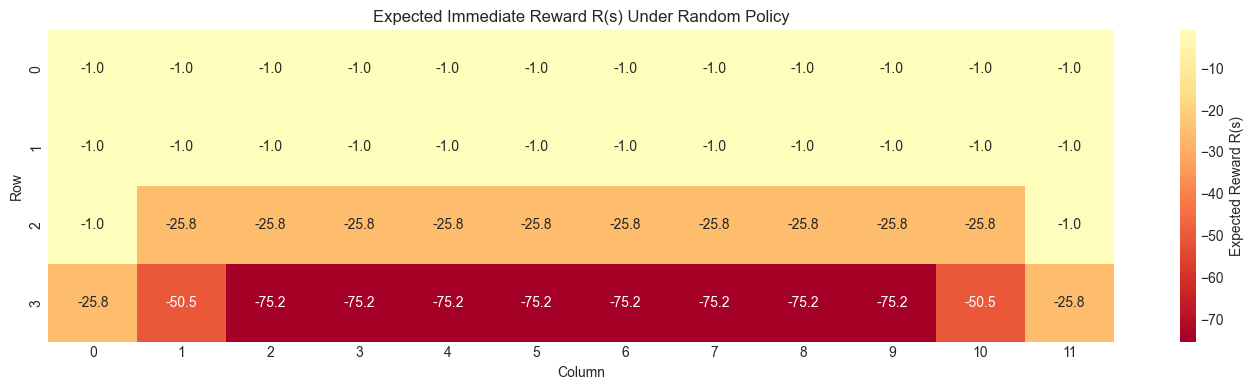


Observations:
- Most states have R(s) ≈ -1 (just the step penalty)
- States adjacent to cliff have R(s) < -1 (risk of -100 penalty)
- State 36 (Start): R = -25.8 (can step onto cliff!)
- State 47 (Goal): R = -25.8 (terminal, but transitions exist)


In [14]:
# Visualize rewards
print("**Question this heatmap answers:** 'What are the expected immediate rewards?'\n")

fig, ax = plt.subplots(figsize=(14, 4))

R_grid = R_mrp.reshape(4, 12)
im = sns.heatmap(R_grid, annot=True, fmt='.1f', cmap='RdYlGn', center=0,
                 cbar_kws={'label': 'Expected Reward R(s)'}, ax=ax)

ax.set_title('Expected Immediate Reward R(s) Under Random Policy', fontsize=12)
ax.set_xlabel('Column')
ax.set_ylabel('Row')

plt.tight_layout()
plt.show()

print("\nObservations:")
print("- Most states have R(s) ≈ -1 (just the step penalty)")
print("- States adjacent to cliff have R(s) < -1 (risk of -100 penalty)")
print(f"- State 36 (Start): R = {R_mrp[36]:.1f} (can step onto cliff!)")
print(f"- State 47 (Goal): R = {R_mrp[47]:.1f} (terminal, but transitions exist)")

In [15]:
def solve_mrp_bellman(P, R, gamma):
    """
    Solve MRP Bellman equation: V = R + γPV
    Solution: V = (I - γP)^(-1) × R
    """
    n = len(R)
    I = np.eye(n)
    V = np.linalg.solve(I - gamma * P, R)
    return V

# Solve for value function
gamma = 0.99
V_mrp = solve_mrp_bellman(P_chain, R_mrp, gamma)

print(f"MRP Value Function (γ = {gamma})")
print("=" * 50)
print(f"\nValue function reshaped as 4×12 grid:")
print(V_mrp.reshape(4, 12).round(1))

MRP Value Function (γ = 0.99)

Value function reshaped as 4×12 grid:
[[ -940.7  -946.1  -951.8  -956.1  -958.8  -960.   -960.   -958.8  -956.1
   -951.8  -946.1  -940.7]
 [ -969.2  -979.9  -987.7  -992.4  -994.9  -996.   -996.   -994.9  -992.4
   -987.7  -979.9  -969.2]
 [-1022.2 -1052.2 -1062.6 -1066.7 -1068.6 -1069.3 -1069.3 -1068.6 -1066.7
  -1062.6 -1052.2 -1022.2]
 [-1082.5 -1114.7 -1142.  -1143.  -1143.5 -1143.7 -1143.7 -1143.5 -1143.
  -1142.  -1114.7 -1082.5]]


**Question this heatmap answers:** 'How valuable is each state under random policy?'



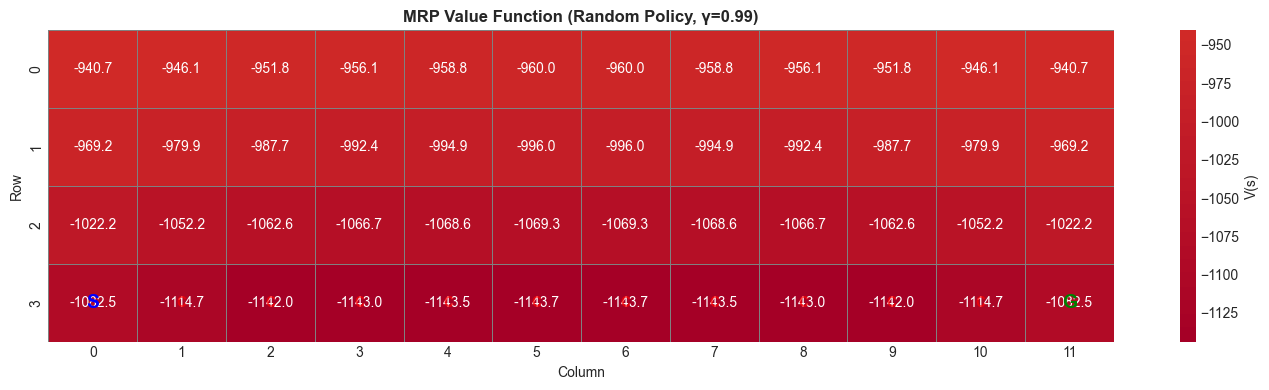


Observations:
- All values are NEGATIVE (every step costs -1, cliff costs -100)
- Values near goal are less negative (shorter expected path)
- Start state: V(36) = -1082.5
- Near goal: V(35) = -1022.2
- Cliff states have very negative values (frequent -100 penalties)


In [16]:
def visualize_value_function(V, title="Value Function V(s)"):
    """Visualize value function on 4×12 grid."""
    fig, ax = plt.subplots(figsize=(14, 4))
    
    V_grid = V.reshape(4, 12)
    im = sns.heatmap(V_grid, annot=True, fmt='.1f', cmap='RdYlGn', center=0,
                     cbar_kws={'label': 'V(s)'}, ax=ax,
                     linewidths=0.5, linecolor='gray')
    
    # Mark special states
    ax.text(0.5, 3.5, 'S', ha='center', va='center', fontsize=14, 
            fontweight='bold', color='blue')
    ax.text(11.5, 3.5, 'G', ha='center', va='center', fontsize=14,
            fontweight='bold', color='green')
    for col in range(1, 11):
        ax.text(col + 0.5, 3.5, 'C', ha='center', va='center', fontsize=10,
                fontweight='bold', color='red', alpha=0.7)
    
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')
    
    plt.tight_layout()
    return fig, ax

print("**Question this heatmap answers:** 'How valuable is each state under random policy?'\n")

visualize_value_function(V_mrp, f"MRP Value Function (Random Policy, γ={gamma})")
plt.show()

print("\nObservations:")
print("- All values are NEGATIVE (every step costs -1, cliff costs -100)")
print("- Values near goal are less negative (shorter expected path)")
print(f"- Start state: V(36) = {V_mrp[36]:.1f}")
print(f"- Near goal: V(35) = {V_mrp[35]:.1f}")
print("- Cliff states have very negative values (frequent -100 penalties)")

## 2.4 Markov Decision Process (MDP)

Recall from notebook 02_3: An **MDP** adds actions to an MRP: $(S, A, P, R, \gamma)$

Now $P(s'|s,a)$ depends on the action, and we have the full decision-making framework.

In [17]:
def extract_mdp_components(env):
    """
    Extract MDP components (S, A, P, R) from Gymnasium environment.
    Returns:
        T[s, a, s']: transition probability
        R[s, a]: expected reward for state-action pair
        terminals: set of terminal states
    """
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    
    T = np.zeros((n_states, n_actions, n_states))
    R = np.zeros((n_states, n_actions))
    terminals = set()
    
    for s in range(n_states):
        for a in range(n_actions):
            for prob, next_s, reward, done in env.unwrapped.P[s][a]:
                T[s, a, next_s] += prob
                R[s, a] += prob * reward
                if done:
                    terminals.add(next_s)
    
    return T, R, terminals

# Extract MDP components
T_mdp, R_mdp, terminal_states = extract_mdp_components(env)

print("MDP Components Extracted")
print("=" * 50)
print(f"\nState space S: {n_states} states (0 to 47)")
print(f"Action space A: {n_actions} actions (UP, RIGHT, DOWN, LEFT)")
print(f"Transition tensor T shape: {T_mdp.shape}")
print(f"Reward matrix R shape: {R_mdp.shape}")
print(f"Terminal states: {terminal_states}")
print(f"Discount factor γ: {gamma}")

MDP Components Extracted

State space S: 48 states (0 to 47)
Action space A: 4 actions (UP, RIGHT, DOWN, LEFT)
Transition tensor T shape: (48, 4, 48)
Reward matrix R shape: (48, 4)
Terminal states: {np.int64(47)}
Discount factor γ: 0.99


In [18]:
# Verify that P(s'|s,a) is always 0 or 1 (deterministic)
print("Verifying Deterministic Transitions in MDP")
print("=" * 50)

# Check all unique probability values
unique_probs = np.unique(T_mdp)
print(f"\nUnique probability values in T[s,a,s']: {unique_probs}")

# For each (s,a) pair, count non-zero transitions
transitions_per_sa = (T_mdp > 0).sum(axis=2)
print(f"\nNumber of possible next states per (s,a):")
print(f"  Min: {transitions_per_sa.min()}")
print(f"  Max: {transitions_per_sa.max()}")
print(f"  Mean: {transitions_per_sa.mean():.2f}")

print("\n✓ Confirmed: Every (s,a) pair leads to exactly ONE next state!")
print("  This is the defining characteristic of a deterministic MDP.")

Verifying Deterministic Transitions in MDP

Unique probability values in T[s,a,s']: [0. 1.]

Number of possible next states per (s,a):
  Min: 1
  Max: 1
  Mean: 1.00

✓ Confirmed: Every (s,a) pair leads to exactly ONE next state!
  This is the defining characteristic of a deterministic MDP.


In [19]:
# Show transitions for a specific state
print("Transitions from State 25 (middle of grid)")
print("=" * 50)

test_state = 25
row, col = state_to_pos(test_state)
print(f"State {test_state} is at position (row={row}, col={col})")

print(f"\n{'Action':<10} {'Next State':<12} {'P(s\'|s,a)':<12} {'R(s,a)':<10}")
print("-" * 50)

for a in range(n_actions):
    next_s = np.argmax(T_mdp[test_state, a])  # The one state with P=1
    prob = T_mdp[test_state, a, next_s]
    reward = R_mdp[test_state, a]
    print(f"{action_names[a]:<10} {next_s:<12} {prob:<12.1f} {reward:<10.1f}")

print("\nNote: All probabilities are 1.0 (deterministic transitions).")
print("Rewards are -1 for normal moves, but -100 when landing on the cliff!")
print("State 25 is in row 2 - going DOWN leads to row 3 (the cliff row).")

Transitions from State 25 (middle of grid)
State 25 is at position (row=2, col=1)

Action     Next State   P(s'|s,a)    R(s,a)    
--------------------------------------------------
UP         13           1.0          -1.0      
RIGHT      26           1.0          -1.0      
DOWN       36           1.0          -100.0    
LEFT       24           1.0          -1.0      

Note: All probabilities are 1.0 (deterministic transitions).
Rewards are -1 for normal moves, but -100 when landing on the cliff!
State 25 is in row 2 - going DOWN leads to row 3 (the cliff row).


---
# 3. Value Functions

Now let's compute the state-value function $V^\pi(s)$ and action-value function $Q^\pi(s,a)$ for our random policy.

In [20]:
def compute_V_pi(T, R, policy, gamma, terminals=None):
    """
    Compute V^π using direct solution of Bellman equation.
    Converts MDP+policy to MRP, then solves V = (I - γP)^(-1) R
    Terminal states have V(s) = 0.
    """
    n_states = T.shape[0]
    n_actions = T.shape[1]
    if terminals is None:
        terminals = set()
    
    # Convert to MRP under policy
    P_mrp = np.zeros((n_states, n_states))
    R_mrp = np.zeros(n_states)
    
    for s in range(n_states):
        if s in terminals:
            continue  # Terminal state: no transitions, no rewards
        for a in range(n_actions):
            P_mrp[s] += policy[s, a] * T[s, a]
            R_mrp[s] += policy[s, a] * R[s, a]
    
    # Solve Bellman equation
    I = np.eye(n_states)
    V = np.linalg.solve(I - gamma * P_mrp, R_mrp)
    
    # Ensure terminal states have V=0
    for s in terminals:
        V[s] = 0
    
    return V

def compute_Q_from_V(T, R, V, gamma):
    """
    Compute Q^π from V^π.
    Q(s,a) = R(s,a) + γ × Σ_{s'} P(s'|s,a) × V(s')
    """
    n_states, n_actions = R.shape
    Q = np.zeros((n_states, n_actions))
    
    for s in range(n_states):
        for a in range(n_actions):
            Q[s, a] = R[s, a] + gamma * np.sum(T[s, a] * V)
    
    return Q

# Compute V and Q for random policy
pi_random = np.ones((n_states, n_actions)) / n_actions
V_random = compute_V_pi(T_mdp, R_mdp, pi_random, gamma, terminal_states)
Q_random = compute_Q_from_V(T_mdp, R_mdp, V_random, gamma)

print(f"Value Functions Under Random Policy (γ = {gamma})")
print("=" * 50)
print(f"\nV^π shape: {V_random.shape}")
print(f"Q^π shape: {Q_random.shape}")

Value Functions Under Random Policy (γ = 0.99)

V^π shape: (48,)
Q^π shape: (48, 4)


**Question this heatmap answers:** 'How good is each state under random policy?'



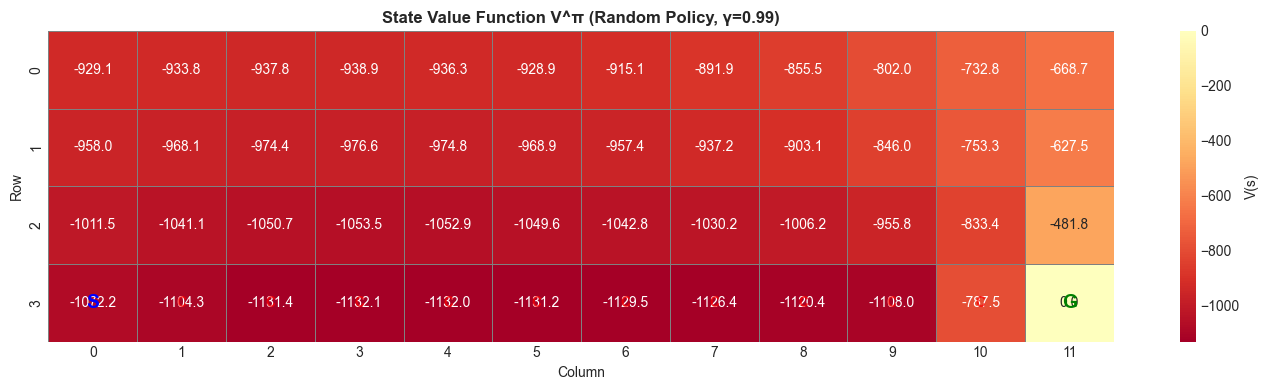


Key values:
  V(36) [Start]: -1072.2
  V(47) [Goal]:  0.0
  V(35) [Near goal]: -481.8


In [21]:
print("**Question this heatmap answers:** 'How good is each state under random policy?'\n")

visualize_value_function(V_random, f"State Value Function V^π (Random Policy, γ={gamma})")
plt.show()

print(f"\nKey values:")
print(f"  V(36) [Start]: {V_random[36]:.1f}")
print(f"  V(47) [Goal]:  {V_random[47]:.1f}")
print(f"  V(35) [Near goal]: {V_random[35]:.1f}")

**Question this plot answers:** 'Which action is best in each state?'



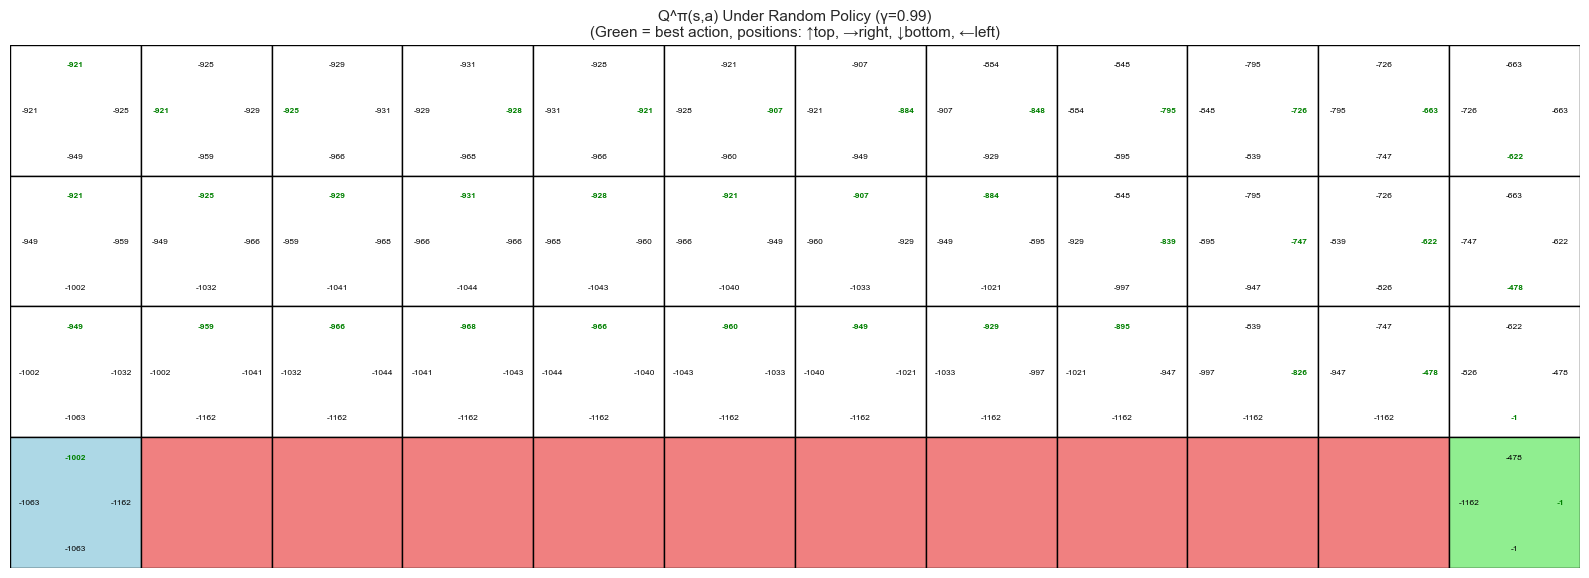


In deterministic environments, Q(s,a) has a clear interpretation:
  Q(s,a) = reward for action a + discounted value of the ONE next state
  No averaging over possible outcomes needed!


In [22]:
def visualize_q_values(Q, title="Q-Values"):
    """Visualize Q-values showing best action in each state."""
    nrow, ncol = 4, 12
    
    fig, ax = plt.subplots(figsize=(16, 6))
    
    for i in range(nrow):
        for j in range(ncol):
            state = i * ncol + j
            
            # Determine cell color
            if state == 36:
                color = 'lightblue'
            elif state == 47:
                color = 'lightgreen'
            elif 37 <= state <= 46:
                color = 'lightcoral'
            else:
                color = 'white'
            
            rect = plt.Rectangle((j, nrow-1-i), 1, 1, fill=True,
                                 facecolor=color, edgecolor='black')
            ax.add_patch(rect)
            
            # Show Q-values for each action
            if not (37 <= state <= 46):  # Not cliff
                best_action = np.argmax(Q[state])
                # UP, RIGHT, DOWN, LEFT positions
                positions = [(0.5, 0.85), (0.85, 0.5), (0.5, 0.15), (0.15, 0.5)]
                
                for a in range(4):
                    x, y = positions[a]
                    q_val = Q[state, a]
                    color = 'green' if a == best_action else 'black'
                    weight = 'bold' if a == best_action else 'normal'
                    ax.text(j + x, nrow - 1 - i + y, f'{q_val:.0f}',
                           ha='center', va='center', fontsize=6,
                           color=color, fontweight=weight)
    
    ax.set_xlim(0, ncol)
    ax.set_ylim(0, nrow)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(f"{title}\n(Green = best action, positions: ↑top, →right, ↓bottom, ←left)", fontsize=11)
    
    plt.tight_layout()
    return fig, ax

print("**Question this plot answers:** 'Which action is best in each state?'\n")

visualize_q_values(Q_random, f"Q^π(s,a) Under Random Policy (γ={gamma})")
plt.show()

print("\nIn deterministic environments, Q(s,a) has a clear interpretation:")
print("  Q(s,a) = reward for action a + discounted value of the ONE next state")
print("  No averaging over possible outcomes needed!")

---
# 4. Policy Iteration

Now let's find the optimal policy using Policy Iteration.

Recall from notebook 03_1:
1. **Policy Evaluation**: Compute $V^\pi$ for current policy
2. **Policy Improvement**: Create greedy policy w.r.t. $V^\pi$
3. **Repeat** until policy stops changing

In [23]:
def policy_evaluation(T, R, policy, gamma, terminals=None, theta=1e-8):
    """
    Iterative policy evaluation.
    Computes V^π until convergence.
    Terminal states have V(s) = 0 (no future rewards).
    """
    n_states = T.shape[0]
    V = np.zeros(n_states)
    if terminals is None:
        terminals = set()
    
    iteration = 0
    while True:
        V_new = np.zeros(n_states)
        
        for s in range(n_states):
            if s in terminals:
                V_new[s] = 0  # Terminal states have no future value
                continue
            # V(s) = Σ_a π(a|s) × [R(s,a) + γ × Σ_{s'} P(s'|s,a) × V(s')]
            for a in range(T.shape[1]):
                V_new[s] += policy[s, a] * (R[s, a] + gamma * np.sum(T[s, a] * V))
        
        # Check convergence
        delta = np.max(np.abs(V_new - V))
        V = V_new
        iteration += 1
        
        if delta < theta:
            break
    
    return V, iteration

In [24]:
def policy_improvement(T, R, V, gamma):
    """
    Create greedy policy w.r.t. value function V.
    π'(s) = argmax_a Q(s,a)
    """
    n_states = T.shape[0]
    n_actions = T.shape[1]
    
    # Compute Q from V
    Q = np.zeros((n_states, n_actions))
    for s in range(n_states):
        for a in range(n_actions):
            Q[s, a] = R[s, a] + gamma * np.sum(T[s, a] * V)
    
    # Greedy policy: deterministic, picks best action
    policy = np.zeros((n_states, n_actions))
    for s in range(n_states):
        best_action = np.argmax(Q[s])
        policy[s, best_action] = 1.0
    
    return policy

In [25]:
def policy_iteration(T, R, gamma, terminals=None, theta=1e-8):
    """
    Full policy iteration algorithm.
    Returns optimal policy and value function.
    """
    n_states = T.shape[0]
    n_actions = T.shape[1]
    if terminals is None:
        terminals = set()
    
    # Start with random policy
    policy = np.ones((n_states, n_actions)) / n_actions
    
    iteration = 0
    eval_iterations = []
    
    while True:
        # Policy Evaluation
        V, n_eval = policy_evaluation(T, R, policy, gamma, terminals, theta)
        eval_iterations.append(n_eval)
        
        # Policy Improvement
        new_policy = policy_improvement(T, R, V, gamma)
        
        # Check if policy changed
        if np.allclose(policy, new_policy):
            print(f"Policy Iteration converged after {iteration + 1} iterations")
            break
        
        policy = new_policy
        iteration += 1
    
    return policy, V, eval_iterations

# Run policy iteration
print("Running Policy Iteration on CliffWalking")
print("=" * 50)

pi_star_pi, V_star_pi, eval_iters = policy_iteration(T_mdp, R_mdp, gamma, terminal_states)

print(f"\nEvaluation iterations per policy improvement: {eval_iters}")
print(f"Total evaluation iterations: {sum(eval_iters)}")

Running Policy Iteration on CliffWalking
Policy Iteration converged after 10 iterations

Evaluation iterations per policy improvement: [2034, 1834, 1834, 1834, 18, 18, 18, 18, 18, 15]
Total evaluation iterations: 7641


**Question this plot answers:** 'What is the optimal policy?'



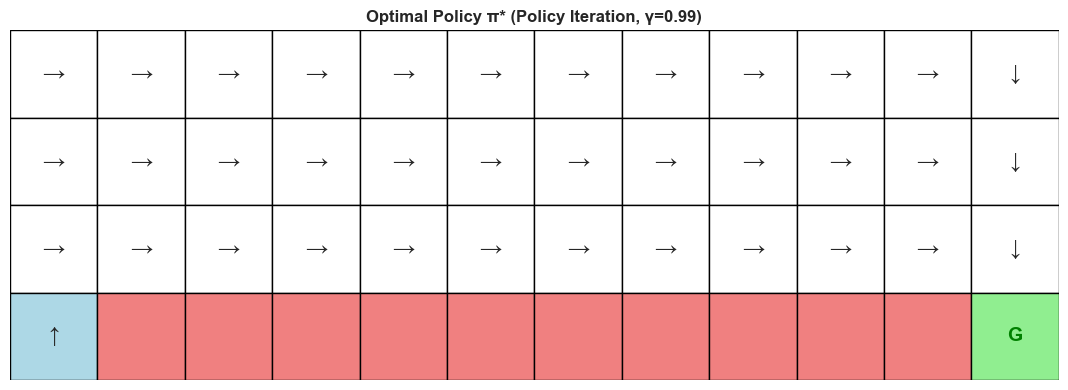


The optimal policy:
- Goes UP from the start to row 2 (safe from cliff)
- Travels RIGHT along row 2 to the rightmost column
- Then goes DOWN to reach the goal
- This is the shortest safe path: 13 steps total


In [26]:
def visualize_policy(policy, title="Policy"):
    """Visualize policy as arrows on the grid."""
    nrow, ncol = 4, 12
    
    fig, ax = plt.subplots(figsize=(14, 4))
    
    for i in range(nrow):
        for j in range(ncol):
            state = i * ncol + j
            
            # Determine cell color
            if state == 36:
                color = 'lightblue'
            elif state == 47:
                color = 'lightgreen'
            elif 37 <= state <= 46:
                color = 'lightcoral'
            else:
                color = 'white'
            
            rect = plt.Rectangle((j, nrow-1-i), 1, 1, fill=True,
                                 facecolor=color, edgecolor='black')
            ax.add_patch(rect)
            
            # Show best action as arrow
            if not (37 <= state <= 46) and state != 47:
                best_action = np.argmax(policy[state])
                ax.text(j + 0.5, nrow - 1 - i + 0.5, action_arrows[best_action],
                       ha='center', va='center', fontsize=16, fontweight='bold')
            elif state == 47:
                ax.text(j + 0.5, nrow - 1 - i + 0.5, 'G',
                       ha='center', va='center', fontsize=14, fontweight='bold',
                       color='green')
    
    ax.set_xlim(0, ncol)
    ax.set_ylim(0, nrow)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title, fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    return fig, ax

# Visualize optimal policy from Policy Iteration
print("**Question this plot answers:** 'What is the optimal policy?'\n")

visualize_policy(pi_star_pi, f"Optimal Policy π* (Policy Iteration, γ={gamma})")
plt.show()

print("\nThe optimal policy:")
print("- Goes UP from the start to row 2 (safe from cliff)")
print("- Travels RIGHT along row 2 to the rightmost column")
print("- Then goes DOWN to reach the goal")
print("- This is the shortest safe path: 13 steps total")

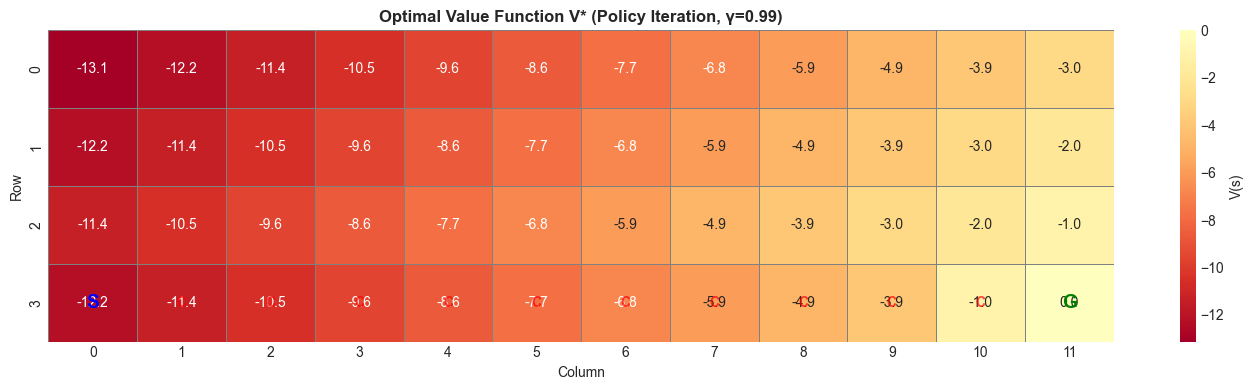


Optimal values:
  V*(36) [Start]: -12.2
  V*(47) [Goal]:  0.0

The optimal path from Start to Goal takes 12 steps.


In [27]:
# Visualize optimal value function
visualize_value_function(V_star_pi, f"Optimal Value Function V* (Policy Iteration, γ={gamma})")
plt.show()

print(f"\nOptimal values:")
print(f"  V*(36) [Start]: {V_star_pi[36]:.1f}")
print(f"  V*(47) [Goal]:  {V_star_pi[47]:.1f}")
print(f"\nThe optimal path from Start to Goal takes {int(-V_star_pi[36])} steps.")

---
# 5. Value Iteration

Now let's find the optimal policy using Value Iteration.

Recall from notebook 03_2:
- Apply Bellman optimality equation: $V(s) \leftarrow \max_a [R(s,a) + \gamma \sum_{s'} P(s'|s,a) V(s')]$
- Repeat until convergence
- Extract policy from final V

In [28]:
def value_iteration(T, R, gamma, terminals=None, theta=1e-8):
    """
    Value iteration algorithm.
    Returns optimal value function and policy.
    Terminal states have V(s) = 0.
    """
    n_states = T.shape[0]
    n_actions = T.shape[1]
    if terminals is None:
        terminals = set()
    
    V = np.zeros(n_states)
    
    iteration = 0
    while True:
        V_new = np.zeros(n_states)
        
        for s in range(n_states):
            if s in terminals:
                V_new[s] = 0  # Terminal states have no future value
                continue
            # V(s) = max_a [R(s,a) + γ × Σ_{s'} P(s'|s,a) × V(s')]
            q_values = np.zeros(n_actions)
            for a in range(n_actions):
                q_values[a] = R[s, a] + gamma * np.sum(T[s, a] * V)
            V_new[s] = np.max(q_values)
        
        # Check convergence
        delta = np.max(np.abs(V_new - V))
        V = V_new
        iteration += 1
        
        if delta < theta:
            print(f"Value Iteration converged after {iteration} iterations")
            break
    
    # Extract optimal policy
    policy = policy_improvement(T, R, V, gamma)
    
    return V, policy, iteration

# Run value iteration
print("Running Value Iteration on CliffWalking")
print("=" * 50)

V_star_vi, pi_star_vi, vi_iters = value_iteration(T_mdp, R_mdp, gamma, terminal_states)

print(f"\nCompare with Policy Iteration total iterations: {sum(eval_iters)}")

Running Value Iteration on CliffWalking
Value Iteration converged after 15 iterations

Compare with Policy Iteration total iterations: 7641


In [29]:
# Verify both methods give the same result
print("Comparing Policy Iteration vs Value Iteration")
print("=" * 50)

# Compare value functions
v_diff = np.max(np.abs(V_star_pi - V_star_vi))
print(f"\nMax difference in V*: {v_diff:.2e}")

# Compare policies
policy_match = np.allclose(pi_star_pi, pi_star_vi)
print(f"Policies match: {policy_match}")

print("\n✓ Both methods find the same optimal solution!")

Comparing Policy Iteration vs Value Iteration

Max difference in V*: 0.00e+00
Policies match: True

✓ Both methods find the same optimal solution!


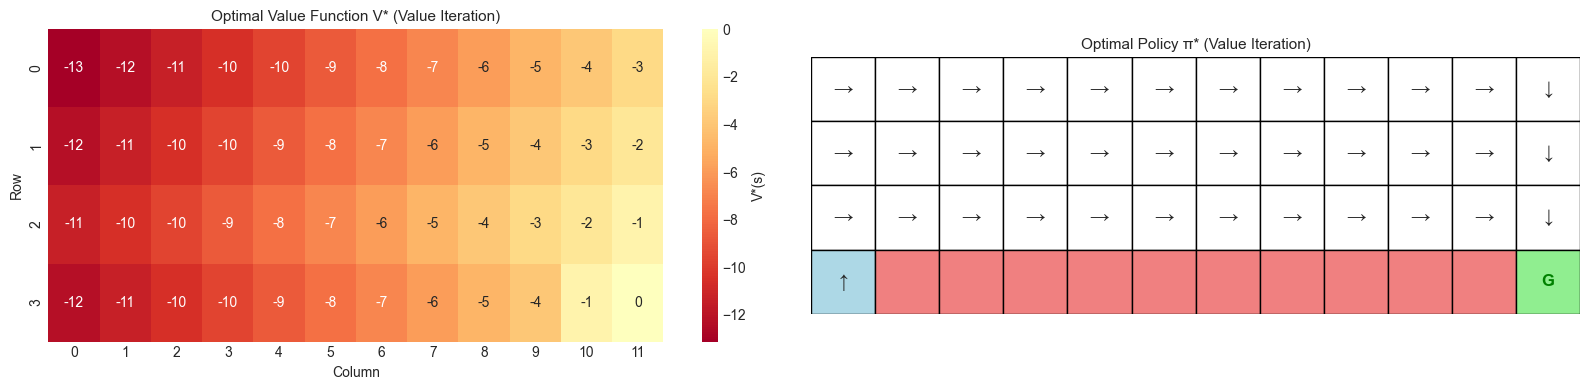

In [30]:
# Visualize Value Iteration results
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Value function
V_grid = V_star_vi.reshape(4, 12)
sns.heatmap(V_grid, annot=True, fmt='.0f', cmap='RdYlGn', center=0,
            ax=axes[0], cbar_kws={'label': 'V*(s)'})
axes[0].set_title(f'Optimal Value Function V* (Value Iteration)', fontsize=11)
axes[0].set_xlabel('Column')
axes[0].set_ylabel('Row')

# Policy
for i in range(4):
    for j in range(12):
        state = i * 12 + j
        if state == 36:
            color = 'lightblue'
        elif state == 47:
            color = 'lightgreen'
        elif 37 <= state <= 46:
            color = 'lightcoral'
        else:
            color = 'white'
        
        rect = plt.Rectangle((j, 3-i), 1, 1, fill=True,
                             facecolor=color, edgecolor='black')
        axes[1].add_patch(rect)
        
        if not (37 <= state <= 46) and state != 47:
            best_action = np.argmax(pi_star_vi[state])
            axes[1].text(j + 0.5, 3 - i + 0.5, action_arrows[best_action],
                        ha='center', va='center', fontsize=14, fontweight='bold')
        elif state == 47:
            axes[1].text(j + 0.5, 3 - i + 0.5, 'G',
                        ha='center', va='center', fontsize=12, fontweight='bold',
                        color='green')

axes[1].set_xlim(0, 12)
axes[1].set_ylim(0, 4)
axes[1].set_aspect('equal')
axes[1].axis('off')
axes[1].set_title('Optimal Policy π* (Value Iteration)', fontsize=11)

plt.tight_layout()
plt.show()

---
# 6. Empirical Evaluation

Let's test our optimal policy by running actual episodes.

In [31]:
def run_episode(env, policy, max_steps=100):
    """Run one episode with given policy."""
    obs, _ = env.reset()
    total_reward = 0
    trajectory = [obs]
    
    for _ in range(max_steps):
        action = np.argmax(policy[obs])  # Deterministic policy
        obs, reward, terminated, truncated, _ = env.step(action)
        total_reward += reward
        trajectory.append(obs)
        
        if terminated or truncated:
            break
    
    return total_reward, trajectory

def evaluate_policy(env, policy, n_episodes=1000):
    """Evaluate policy over multiple episodes."""
    rewards = []
    successes = 0
    
    for _ in range(n_episodes):
        reward, traj = run_episode(env, policy)
        rewards.append(reward)
        if traj[-1] == 47:  # Reached goal
            successes += 1
    
    return np.array(rewards), successes / n_episodes

# Evaluate both policies
print("Evaluating Policies (1000 episodes each)")
print("=" * 50)

env_eval = gym.make("CliffWalking-v1")

# Random policy
rewards_random, success_random = evaluate_policy(env_eval, pi_random, 1000)
print(f"\nRandom Policy:")
print(f"  Success rate: {success_random*100:.1f}%")
print(f"  Average reward: {rewards_random.mean():.1f}")
print(f"  Std reward: {rewards_random.std():.1f}")

# Optimal policy
rewards_optimal, success_optimal = evaluate_policy(env_eval, pi_star_vi, 1000)
print(f"\nOptimal Policy:")
print(f"  Success rate: {success_optimal*100:.1f}%")
print(f"  Average reward: {rewards_optimal.mean():.1f}")
print(f"  Std reward: {rewards_optimal.std():.1f}")

env_eval.close()

Evaluating Policies (1000 episodes each)

Random Policy:
  Success rate: 0.0%
  Average reward: -100.0
  Std reward: 0.0

Optimal Policy:
  Success rate: 100.0%
  Average reward: -13.0
  Std reward: 0.0


In [32]:
print("\n" + "=" * 60)
print("KEY INSIGHT: Determinism + Optimal Policy = Certainty!")
print("=" * 60)

print(f"\nIn FrozenLake (stochastic):")
print(f"  Optimal policy success rate: ~74%")
print(f"  Even the best policy can fail due to random transitions")

print(f"\nIn CliffWalking (deterministic):")
print(f"  Optimal policy success rate: {success_optimal*100:.0f}%")
print(f"  The optimal policy ALWAYS succeeds!")

print("\nThis is the power of determinism:")
print("- The agent has complete control over outcomes")
print("- Once we find the optimal path, we can follow it perfectly")
print("- No uncertainty means no risk of failure")


KEY INSIGHT: Determinism + Optimal Policy = Certainty!

In FrozenLake (stochastic):
  Optimal policy success rate: ~74%
  Even the best policy can fail due to random transitions

In CliffWalking (deterministic):
  Optimal policy success rate: 100%
  The optimal policy ALWAYS succeeds!

This is the power of determinism:
- The agent has complete control over outcomes
- Once we find the optimal path, we can follow it perfectly
- No uncertainty means no risk of failure


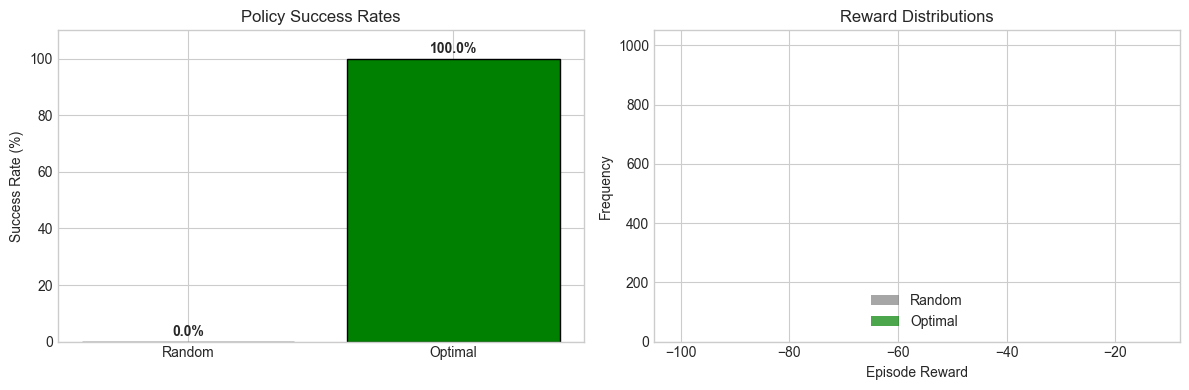

In [33]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Success rates
policies = ['Random', 'Optimal']
success_rates = [success_random * 100, success_optimal * 100]
colors = ['gray', 'green']

bars = axes[0].bar(policies, success_rates, color=colors, edgecolor='black')
axes[0].set_ylabel('Success Rate (%)')
axes[0].set_title('Policy Success Rates')
axes[0].set_ylim(0, 110)
for bar, rate in zip(bars, success_rates):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                f'{rate:.1f}%', ha='center', fontweight='bold')

# Reward distributions
axes[1].hist(rewards_random, bins=50, alpha=0.7, label='Random', color='gray')
axes[1].hist(rewards_optimal, bins=50, alpha=0.7, label='Optimal', color='green')
axes[1].set_xlabel('Episode Reward')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Reward Distributions')
axes[1].legend()

plt.tight_layout()
plt.show()

In [34]:
# Show the optimal path
print("The Optimal Path")
print("=" * 50)

env_demo = gym.make("CliffWalking-v1")
_, optimal_traj = run_episode(env_demo, pi_star_vi)
env_demo.close()

print(f"\nOptimal trajectory ({len(optimal_traj)-1} steps):")
print(f"States: {optimal_traj}")

# Decode actions
print(f"\nStep-by-step:")
for i in range(len(optimal_traj) - 1):
    s = optimal_traj[i]
    s_next = optimal_traj[i + 1]
    action = np.argmax(pi_star_vi[s])
    row, col = state_to_pos(s)
    print(f"  State {s:2d} (row {row}, col {col:2d}) → {action_names[action]:<6} → State {s_next:2d}")

The Optimal Path

Optimal trajectory (13 steps):
States: [36, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 47]

Step-by-step:
  State 36 (row 3, col  0) → UP     → State 24
  State 24 (row 2, col  0) → RIGHT  → State 25
  State 25 (row 2, col  1) → RIGHT  → State 26
  State 26 (row 2, col  2) → RIGHT  → State 27
  State 27 (row 2, col  3) → RIGHT  → State 28
  State 28 (row 2, col  4) → RIGHT  → State 29
  State 29 (row 2, col  5) → RIGHT  → State 30
  State 30 (row 2, col  6) → RIGHT  → State 31
  State 31 (row 2, col  7) → RIGHT  → State 32
  State 32 (row 2, col  8) → RIGHT  → State 33
  State 33 (row 2, col  9) → RIGHT  → State 34
  State 34 (row 2, col 10) → RIGHT  → State 35
  State 35 (row 2, col 11) → DOWN   → State 47


---
# 7. Summary

In this notebook, we applied all the RL concepts from notebooks 01-03_2 to the CliffWalking environment.

## Key Takeaways

### CliffWalking vs FrozenLake

| Aspect | FrozenLake | CliffWalking |
|--------|------------|---------------|
| Grid | 4×4 (16 states) | 4×12 (48 states) |
| Transitions | Stochastic (1/3 each) | **Deterministic** |
| Rewards | Sparse (+1 at goal) | Dense (-1 step, -100 cliff) |
| Optimal success | ~74% | **100%** |
| Algorithm convergence | ~438 iterations | ~15 iterations |

### The Impact of Determinism

```
DETERMINISTIC ENVIRONMENT
=========================

• Policy → Trajectory: Same policy ALWAYS produces same trajectory
• Credit Assignment: Clear cause and effect
• Optimal Policy: Achieves 100% success (no uncertainty)
• Value Functions: No averaging over outcomes needed
• Convergence: Much faster (less uncertainty to resolve)
```

### Important: Terminal States

When implementing value iteration or policy iteration, terminal states must be handled correctly:
- Terminal states have V(s) = 0 (no future rewards possible)
- The goal state (47) is terminal in CliffWalking
- Forgetting this leads to incorrect optimal policies!

### Concepts Applied

```
Markov Property  →  Markov Chain  →  MRP  →  MDP
     ↓                  ↓            ↓        ↓
   Verified       Transition    Rewards   Actions
                   Matrix P       R(s)    P(s'|s,a)
                                           
                                  Value Functions
                                    V(s), Q(s,a)
                                        ↓
                              ┌─────────┴─────────┐
                              ↓                   ↓
                      Policy Iteration    Value Iteration
                              ↓                   ↓
                              └─────────┬─────────┘
                                        ↓
                                  Optimal π*
                                        ↓
                                  100% Success!
```

## What's Next?

In notebooks 04-06, we'll learn **model-free methods** that don't require knowing the transition probabilities:
- Monte Carlo methods (learn from complete episodes)
- Temporal Difference learning (learn from partial episodes)
- Q-learning and SARSA

---

**Congratulations!** You've successfully applied all the foundational RL concepts to a new environment.

Key achievements:
- Built Markov chains, MRPs, and MDPs for CliffWalking
- Understood how determinism simplifies everything
- Ran Policy Iteration and Value Iteration
- Achieved 100% success with the optimal policy

Next: 04_monte_carlo.ipynb - Learning without a model!